# Neural Networks for Time Series

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A notebook from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).


## Preamble

This lab session deals with the use of neural networks for time series classification and forecasting.
Two kinds of architectures are considered here: convolutional and recurrent models.

## Time Series Classification using convolutional models (ConvNets)

For a start, you will load the "Trace" dataset using [`tslearn` data loading tool](https://tslearn.readthedocs.io/en/latest/gen_modules/datasets/tslearn.datasets.CachedDatasets.html#tslearn.datasets.CachedDatasets.load_dataset).

**Question #1.** What are the dimensions of the training data (`X_train`)? And what does each dimension correspond to (number of series, number of timestamps, number of features, ...)?
Also, `keras` expects class information to be encoded as one-hot vectors. Use [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) to format your `y` arrays accordingly.


In [2]:
from tslearn.datasets import CachedDatasets

data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")
print(X_train.shape)

y_train -= 1
y_test -= 1

print(set(y_train))

(100, 275, 1)
{0, 1, 2, 3}


**Question #2.** In the following, you will be implementing a ConvNet using keras' [`Conv1D`](https://keras.io/api/layers/convolution_layers/convolution1d/) layers.
What value should be passed to the `data_format` parameter to match `tslearn` format? Is it the default value?

The default is `"channels_last"`, which is what we need.

**Question #3.** `keras` has a `Sequential` model class that allows to build models by stacking layers.
Define a model that is made of the following layers (use ReLU activation wherever it makes sense):

* a convolution layer made of 10 filters of size 3
* a pooling layer of pool size 2
* a flatten layer (that converts a time series of features into a flattened array that is suited to feed fully-connected layers)
* a fully-connected layer that has as many neurons as the number of classes in the "Trace" problem, and an adequate activation function.

Compile your model (use "Adam" optimizer) and fit it for 10 epochs.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense

model = Sequential([
    Conv1D(filters=10, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

2023-01-30 09:41:14.913425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


2023-01-30 09:41:26.584385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4/4 [==============================] - 1s 105ms/step - loss: 1.6205 - accuracy: 0.1900 - val_loss: 1.2165 - val_accuracy: 0.4900
Epoch 2/10
4/4 [==============================] - 0s 20ms/step - loss: 1.1082 - accuracy: 0.5100 - val_loss: 0.9785 - val_accuracy: 0.4300
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 0.8931 - accuracy: 0.5800 - val_loss: 0.8946 - val_accuracy: 0.4900
Epoch 4/10
4/4 [==============================] - 0s 32ms/step - loss: 0.7843 - accuracy: 0.6000 - val_loss: 0.8033 - val_accuracy: 0.4800
Epoch 5/10
4/4 [==============================] - 0s 35ms/step - loss: 0.7124 - accuracy: 0.6500 - val_loss: 0.7453 - val_accuracy: 0.4800
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 0.6859 - accuracy: 0.6700 - val_loss: 0.7427 - val_accuracy: 0.5500
Epoch 7/10
4/4 [==============================] - 0s 21ms/step - loss: 0.6619 - accuracy: 0.7100 - val_loss: 0.7598 - val_accuracy: 0.4600
Epoch 8/10
4/4 [=====================

**Question #4.** Plot the evolution of accuracy through epochs on both training and validation sets.

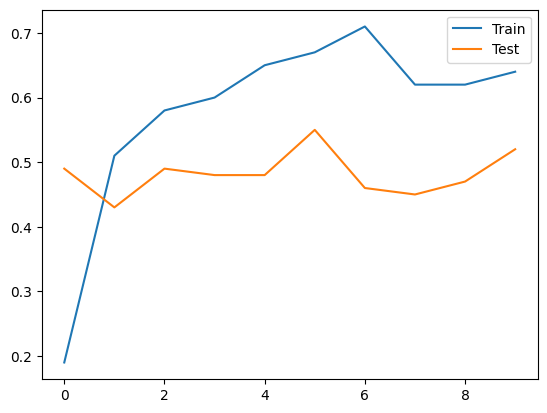

In [4]:
import matplotlib.pyplot as plt

plt.plot(h.history["accuracy"], label="Train")
plt.plot(h.history["val_accuracy"], label="Test")
plt.legend();

**Question #5.** Ten epochs of training might not be sufficient, yet we do not know how many epochs would be necessary for a decent training. Set up early stopping (cf. [this callback](https://keras.io/api/callbacks/early_stopping/)) and see how long it takes before the model stops training.

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True
)
model = Sequential([
    Conv1D(filters=10, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Conv1D(filters=20, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[cb])

Epoch 1/100
4/4 [==============================] - 1s 68ms/step - loss: 1.4240 - accuracy: 0.0400 - val_loss: 1.3020 - val_accuracy: 0.3900
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 1.2484 - accuracy: 0.5200 - val_loss: 1.1617 - val_accuracy: 0.4900
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 1.1090 - accuracy: 0.5800 - val_loss: 1.0360 - val_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 0s 31ms/step - loss: 0.9947 - accuracy: 0.5600 - val_loss: 0.9319 - val_accuracy: 0.4700
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.8899 - accuracy: 0.5500 - val_loss: 0.8522 - val_accuracy: 0.4700
Epoch 6/100
4/4 [==============================] - 0s 26ms/step - loss: 0.8086 - accuracy: 0.5700 - val_loss: 0.7873 - val_accuracy: 0.5200
Epoch 7/100
4/4 [==============================] - 0s 28ms/step - loss: 0.7479 - accuracy: 0.6400 - val_loss: 0.7471 - val_accuracy: 0.5600
Epoch 8/100
4/4 [===

## Recurrent neural nets

For this new part of the lab, we will use the data generated from the function below:

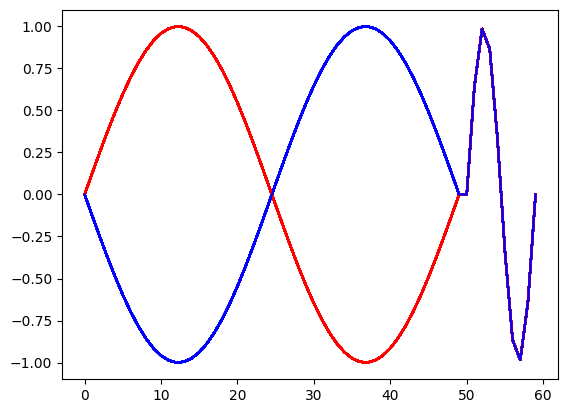

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def make_sines(n_series_per_class, length, length_padding=0):
    t = np.linspace(0, 2 * np.pi, num=length)
    X0 = .005 * np.random.randn(n_series_per_class, length + length_padding)
    X0[:, :length] = np.sin(t).reshape((1, -1))
    X0[:, length:] = np.sin(np.linspace(0, 2 * np.pi, num=length_padding))
    
    X1 = .005 * np.random.randn(n_series_per_class, length + length_padding)
    X1[:, :length] = np.sin(-t).reshape((1, -1))
    X1[:, length:] = np.sin(np.linspace(0, 2 * np.pi, num=length_padding))

    dataset = np.array([X0, X1]).reshape((2 * n_series_per_class, length + length_padding, 1))
    y = np.array([0] * n_series_per_class + [1] * n_series_per_class)

    indices = np.random.permutation(2 * n_series_per_class)
    return dataset[indices], y[indices]

np.random.seed(0)
X, y = make_sines(100, 50, length_padding=10)

plt.figure()
colors = ["r", "b"]
for ts, yi in zip(X, y):
    plt.plot(ts.ravel(), color=colors[yi])
plt.show()

**Question #7.** Implement your own recurrent layer (_cf._ formulas in the course) using the skeleton below and train a network
made of a single recurrent unit with a 8-dimensional hidden state followed by a fully connected layer, and evaluate its classification 
performance on the dataset provided above.

In [8]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class CustomRecurrentUnit(Layer):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        # List sets of parameters here
        self.w_h = self.add_weight(
            shape=(hidden_dim, hidden_dim), initializer="random_normal", trainable=True
        )
        self.b_h = self.add_weight(shape=(hidden_dim,), initializer="zeros", trainable=True)
        self.w_i = self.add_weight(
            shape=(input_dim, hidden_dim), initializer="random_normal", trainable=True
        )
        self.b_i = self.add_weight(shape=(hidden_dim,), initializer="zeros", trainable=True)
    
    def linear_hidden(self, h_t):
        return h_t @ self.w_h + self.b_h
    
    def linear_input(self, x_t):
        return x_t @ self.w_i + self.b_i
    
    def call(self, x):
        n_timestamps = x.shape[1]
        h = tf.zeros((1, self.hidden_dim))  # Initialize h to [0, ..., 0]
        for t in range(n_timestamps):
            h = tf.tanh(self.linear_hidden(h) + self.linear_input(x[:, t]))
        return h

In [9]:
from tensorflow.keras.callbacks import Callback

class CustomLogging(Callback):
    def __init__(self, every_n_epochs=10):
        super().__init__()
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.every_n_epochs == self.every_n_epochs - 1:
            # accuracy = self.model.evaluate(*self.training_data)
            print(f"Training loss after epoch {epoch}: {logs['loss']}")

**Question #8.** Implement a network made of a `CustomRecurrentUnit` followed by a fully-connected layer
for the classification task introduced above.
Evaluate this model both in terms of training loss and test-set accuracy (you can use the above callback to limit the amount of logging).

In [15]:
X, y = make_sines(100, 50, length_padding=5)
X_test, y_test = make_sines(100, 50, length_padding=5)

model = Sequential([
    CustomRecurrentUnit(input_dim=1, hidden_dim=100),
    Dense(units=1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 [==============================] - 7s 255ms/step - loss: 0.6969 - accuracy: 0.5000 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 0s 24ms/step - loss: 0.6867 - accuracy: 0.5700 - val_loss: 0.6330 - val_accuracy: 0.5000
Epoch 3/100
7/7 [==============================] - 0s 24ms/step - loss: 0.3939 - accuracy: 0.9250 - val_loss: 0.0841 - val_accuracy: 1.0000
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 0.0462 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 6/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 8/100
7/7 [==

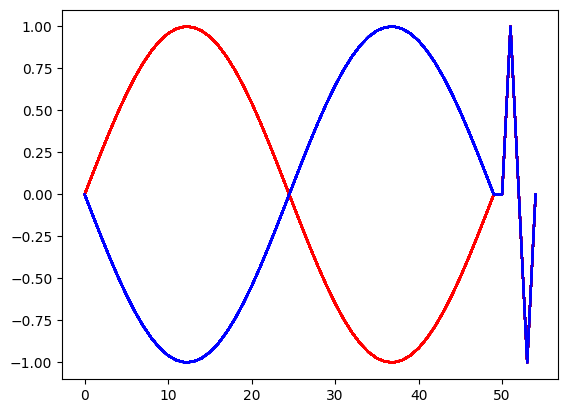

In [14]:
plt.figure()
colors = ["r", "b"]
for ts, yi in zip(X, y):
    plt.plot(ts.ravel(), color=colors[yi])
plt.show()

**Question #9.** Update your dataset so that it includes a final padding of 15 timestamps (_cf._ signature of the `make_sines` function)
and see how it impacts performance of your model.

In [17]:
X, y = make_sines(100, 50, length_padding=25)
X_test, y_test = make_sines(100, 50, length_padding=25)

model = Sequential([
    CustomRecurrentUnit(input_dim=1, hidden_dim=100),
    Dense(units=1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
7/7 [==============================] - 9s 217ms/step - loss: 0.6961 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 0s 27ms/step - loss: 0.6937 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/100
7/7 [==============================] - 0s 25ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/100
7/7 [==============================] - 0s 28ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
7/7 [==============================] - 0s 30ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/100
7/7 [==============================] - 0s 25ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 8/100
7/7 [==

**Question #10.** Build GRU (resp. LSTM) counterparts of the RNN-based model above.
How do they compare experimentally to the previous model?

In [19]:
from tensorflow.keras.layers import LSTM

X, y = make_sines(100, 50, length_padding=50)
X_test, y_test = make_sines(100, 50, length_padding=50)

model = Sequential([
    LSTM(units=100),
    Dense(units=1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
7/7 [==============================] - 4s 166ms/step - loss: 0.6944 - accuracy: 0.4800 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - 1s 97ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/10
7/7 [==============================] - 1s 91ms/step - loss: 0.6947 - accuracy: 0.5000 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 4/10
7/7 [==============================] - 1s 91ms/step - loss: 0.6961 - accuracy: 0.5000 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 5/10
7/7 [==============================] - 1s 91ms/step - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 6/10
7/7 [==============================] - 1s 163ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/10
7/7 [==============================] - 1s 96ms/step - loss: 0.6947 - accuracy: 0.4000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/10
7/7 [=========

In [27]:
from tensorflow.keras.layers import GRU, GlobalMaxPooling1D, Flatten

X, y = make_sines(100, 50, length_padding=100)
X_test, y_test = make_sines(100, 50, length_padding=100)

model = Sequential([
    GRU(units=5, return_sequences=True),
    Flatten(),
    Dense(units=1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
7/7 [==============================] - 3s 151ms/step - loss: 0.7260 - accuracy: 0.2450 - val_loss: 0.6323 - val_accuracy: 1.0000
Epoch 2/10
7/7 [==============================] - 1s 79ms/step - loss: 0.5841 - accuracy: 1.0000 - val_loss: 0.5070 - val_accuracy: 1.0000
Epoch 3/10
7/7 [==============================] - 1s 74ms/step - loss: 0.4668 - accuracy: 1.0000 - val_loss: 0.3993 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 1s 81ms/step - loss: 0.3635 - accuracy: 1.0000 - val_loss: 0.3085 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 1s 76ms/step - loss: 0.2791 - accuracy: 1.0000 - val_loss: 0.2337 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 1s 84ms/step - loss: 0.2100 - accuracy: 1.0000 - val_loss: 0.1747 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 1s 75ms/step - loss: 0.1572 - accuracy: 1.0000 - val_loss: 0.1307 - val_accuracy: 1.0000
Epoch 8/10
7/7 [==========

## Recap

**Question #11.** Come back to the "Trace" dataset used above and design a fair comparison between several convolutional and recurrent architectures to decide which one to choose for the problem at hand (feel free to play with the depth of the nets, as well as hidden representation dimensionality, etc.).

In [30]:
from tslearn.datasets import CachedDatasets

data_loader = CachedDatasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("Trace")
print(X_train.shape)

y_train -= 1
y_test -= 1


feature_extractors = {
    "Conv_1layer": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu")
    ]),
    "Conv_2layers": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
    ]),
    "Conv_3layers": Sequential([
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
        Conv1D(filters=25, kernel_size=5, activation="relu"),
    ]),
    "LSTM_1layer": Sequential([
        LSTM(units=25, return_sequences=True)
    ]),
    "LSTM_2layers": Sequential([
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True),
    ]),
    "LSTM_3layers": Sequential([
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True),
        LSTM(units=25, return_sequences=True)
    ]),
}

for name, f in feature_extractors.items():
    model = Sequential([
        f,
        Flatten(),
        Dense(units=4, activation="softmax")
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    h = model.fit(X_train, y_train, epochs=10, verbose=False)
    print(name, model.evaluate(X_test, y_test))

(100, 275, 1)
4/4 [==============================] - 0s 3ms/step - loss: 0.7035 - accuracy: 0.5400
Conv_1layer [0.7034642696380615, 0.5400000214576721]
4/4 [==============================] - 0s 3ms/step - loss: 0.7139 - accuracy: 0.5600
Conv_2layers [0.7138922214508057, 0.5600000023841858]
4/4 [==============================] - 0s 13ms/step - loss: 0.7853 - accuracy: 0.5300
Conv_3layers [0.7853028774261475, 0.5299999713897705]
4/4 [==============================] - 1s 23ms/step - loss: 0.8034 - accuracy: 0.5400
LSTM_1layer [0.8034000396728516, 0.5400000214576721]
4/4 [==============================] - 1s 51ms/step - loss: 0.7201 - accuracy: 0.4800
LSTM_2layers [0.7201007008552551, 0.47999998927116394]
4/4 [==============================] - 1s 64ms/step - loss: 0.8098 - accuracy: 0.4900
LSTM_3layers [0.8098486065864563, 0.49000000953674316]


# Bonus: visualizing feature importance

An important topic in machine learning is interpretability, which is about explaining model-based decisions.
Regarding neural networks, a large body of the interpretability litterature relies on showing which parts of the input data is most important for a decision.

A way to visualize the importance of input features on a given decision is to compute gradients of the model's output with respect to its input.

The function below does it:

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model

def make_gradient_heatmap(batch_of_time_series, model):
    inputs = tf.convert_to_tensor(batch_of_time_series, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        preds = model(inputs)
        output_channel = preds[:, 0]

    # This is the gradient of the output neuron
    # with respect to the input data
    grads = tf.abs(tape.gradient(output_channel, inputs))
    grads = grads / tf.reduce_max(grads, axis=1, keepdims=True)

    return grads.numpy()

**Question #12.** Getting back to the binary decision problem with padded sines, visualize the importance of input features in the final decision for:
* a network with one LSTM layer
* a network with one convolutional layer

In [31]:
X, y = make_sines(100, 50, length_padding=100)

rec_model = Sequential([
    LSTM(units=25),
    Flatten(),
    Dense(units=1, activation="sigmoid")
])
rec_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = rec_model.fit(X, y, epochs=30, verbose=0)

conv_model = Sequential([
    Conv1D(filters=25, kernel_size=5),
    Flatten(),
    Dense(units=1, activation="sigmoid")
])
conv_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
h = conv_model.fit(X, y, epochs=30, verbose=0)

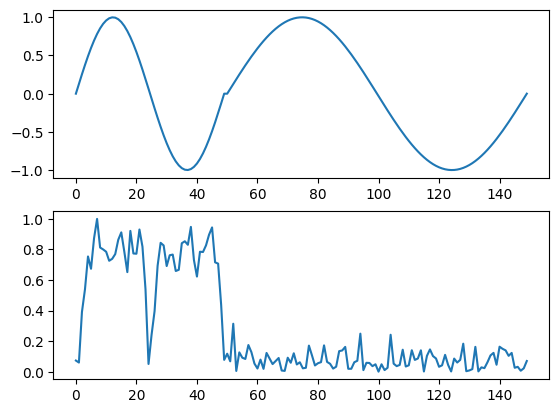

In [34]:
grads = make_gradient_heatmap(X, conv_model)

plt.subplot(2, 1, 1)
plt.plot(X[0, :, 0])
plt.subplot(2, 1, 2)
plt.plot(grads[0, :, 0])

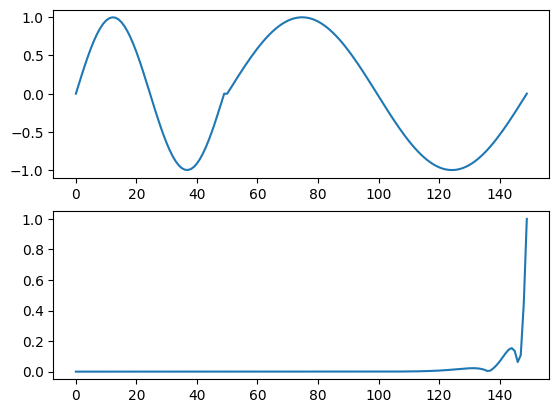

In [35]:
grads = make_gradient_heatmap(X, rec_model)

plt.subplot(2, 1, 1)
plt.plot(X[0, :, 0])
plt.subplot(2, 1, 2)
plt.plot(grads[0, :, 0])